In [19]:
from scipy.interpolate import UnivariateSpline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
dye = 'MCP'

bkg_scan = 'DyeCal/MCP_cal_FLMS170641__0__00000.txt'
blank_scan = 'DyeCal/MCP_cal_FLMS170641__2__00002.txt'
acid_scan = 'DyeCal/MCP_cal_FLMS170641__7__00007.txt'
base_scan = 'DyeCal/MCP_cal_FLMS170641__6__00006.txt'

from carbspec.dye import splines
old_splines = splines.load_splines(dye)

In [35]:
bkg = pd.read_csv(bkg_scan, delim_whitespace=True, skiprows=14, header=None)
bkg.columns = ['wv', 'I']

blank = pd.read_csv(blank_scan, delim_whitespace=True, skiprows=14, header=None)
blank.columns = ['wv', 'I']

base = pd.read_csv(base_scan, delim_whitespace=True, skiprows=14, header=None)
base.columns = ['wv', 'I']

acid = pd.read_csv(acid_scan, delim_whitespace=True, skiprows=14, header=None)
acid.columns = ['wv', 'I']

In [36]:
base['I_bkg'] = base['I'] -bkg['I']
acid['I_bkg'] = acid['I'] - bkg['I']
blank['I_bkg'] = blank['I'] - bkg['I']

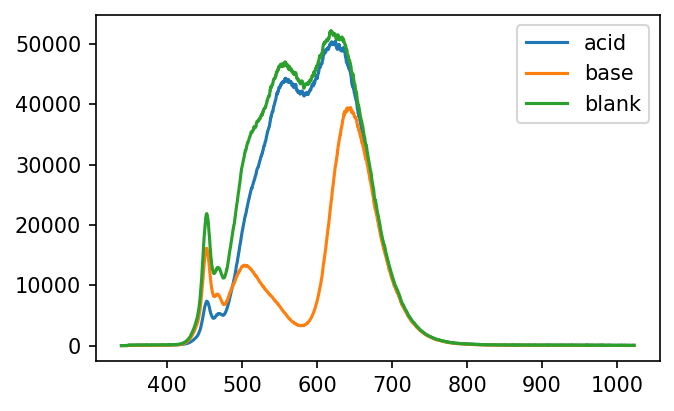

In [37]:
plt.plot(acid['wv'], acid['I_bkg'], label='acid')
plt.plot(base['wv'], base['I_bkg'], label='base')
plt.plot(blank['wv'], blank['I_bkg'], label='blank')

plt.legend()

In [38]:
acid['abs'] = np.log10(blank['I_bkg'] / acid['I_bkg'])
base['abs'] = np.log10(blank['I_bkg'] / base['I_bkg'])

/usr/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [94]:
# isolate useful region
clip = 400, 750
ind = (acid['wv'] >= clip[0]) & (acid['wv'] <= clip[1])

acid = acid.loc[ind]
base = base.loc[ind]

In [104]:
# smooth spectra
boxcar_width = 11
acid['abs_sm'] = acid['abs'].rolling(boxcar_width, center=True, min_periods=1).mean()
base['abs_sm'] = base['abs'].rolling(boxcar_width, center=True, min_periods=1).mean()

In [108]:
# zero background
bkg_loc = 690.
bkg_width = 5.

bkg_ind = (acid['wv'] >= bkg_loc - bkg_width / 2) & (acid['wv'] <= bkg_loc + bkg_width / 2)

acid['abs_norm'] = acid['abs_sm'] - acid.loc[bkg_ind, 'abs_sm'].mean()
base['abs_norm'] = base['abs_sm'] - base.loc[bkg_ind, 'abs_sm'].mean()

In [109]:
# normalise to max 1
norm = base['abs_sm'].sort_values().tail(5).mean()

base['abs_norm'] = base['abs_norm'] / norm
acid['abs_norm'] = acid['abs_norm'] / norm

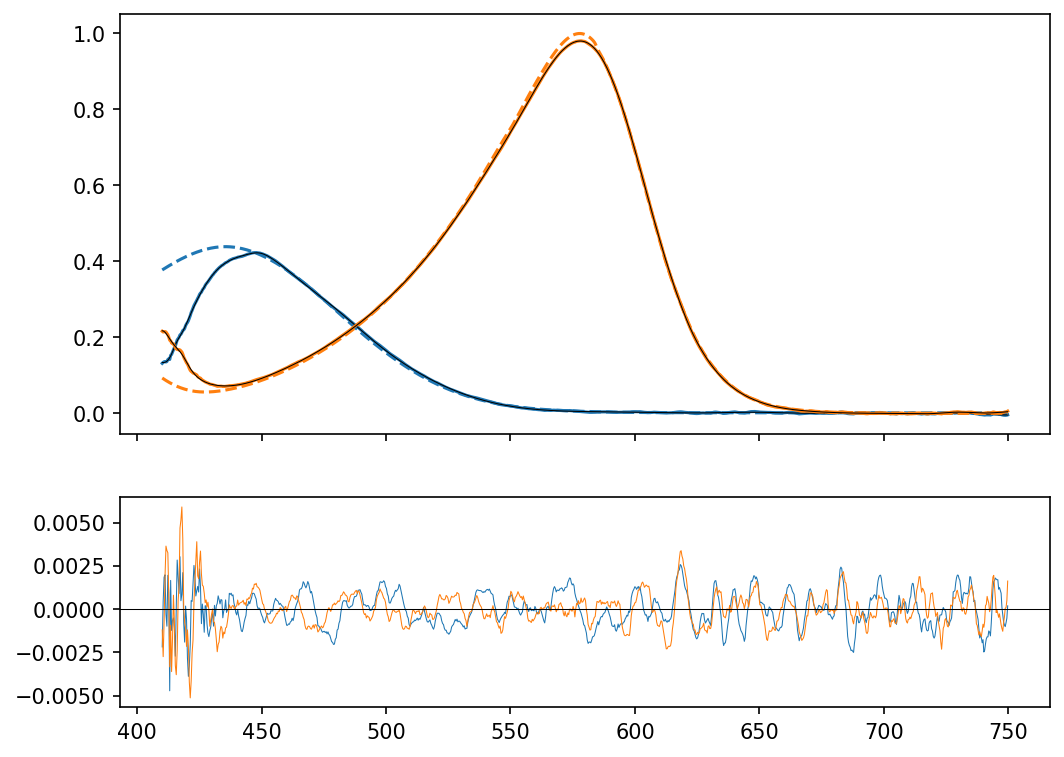

In [110]:

s = 0.001
acid_spline = UnivariateSpline(acid['wv'][ind], acid['abs_norm'][ind], s=s)
base_spline = UnivariateSpline(base['wv'][ind], base['abs_norm'][ind], s=s)

fig, axs = plt.subplots(2, 1, figsize=[8,6], sharex=True, height_ratios=[2,1])
ax1, ax2 = axs

ax1.plot(acid['wv'][ind], acid['abs_norm'][ind], label='acid', color='C0')
ax1.plot(acid['wv'][ind], old_splines['acid'](acid['wv'][ind]), ls='--', color='C0', label='old acid')
ax1.plot(acid['wv'][ind], acid_spline(acid['wv'][ind]), ls='-', color='k', lw=0.5, label='new acid')

ax1.plot(base['wv'][ind], base['abs_norm'][ind], label='base', color='C1')
ax1.plot(base['wv'][ind], old_splines['base'](acid['wv'][ind]), ls='--', color='C1', label='old base')
ax1.plot(base['wv'][ind], base_spline(acid['wv'][ind]), ls='-', color='k', lw=0.5, label='new base')

acid_resid = acid['abs_norm'][ind] - acid_spline(acid['wv'][ind])
base_resid = base['abs_norm'][ind] - base_spline(acid['wv'][ind])

ax2.plot(acid['wv'][ind], acid_resid, color='C0', lw=0.5)
ax2.plot(base['wv'][ind], base_resid, color='C1', lw=0.5)
ax2.axhline(0, color='k', lw=0.5)

In [111]:
splines.save_spline(acid_spline, 'MCP_Cam1', 'acid', overwrite=True)
splines.save_spline(base_spline, 'MCP_Cam1', 'base', overwrite=True)